In [1]:
!git clone https://github.com/valerkabvv/pruning-resnet20.git

Cloning into 'pruning-resnet20'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 106 (delta 59), reused 79 (delta 32), pack-reused 0
Receiving objects: 100% (106/106), 1016.62 KiB | 1.18 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [1]:
import sys
sys.path.append('pruning-resnet20')
from models.resnet import resnet20
from torchsummary import summary
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

from data.CIFAR10_transforms import cifar_transform_train, cifar_transform_test
from training_utils.training import train, validate
from training_utils.training import train
from training_utils.kmeans_prune import get_pruned_model

In [2]:
dataset_train = CIFAR10(download = True, root = './', transform = cifar_transform_train)
dataset_test = CIFAR10(train = False, download = True, root = './', transform = cifar_transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# summary(resnet20().cuda(), (3,32,32))

In [4]:
## раскоментировать для обучения модели
# !python /content/pruning-resnet20/train_resnet20_cifar10.py

In [3]:
md = resnet20()
md.load_state_dict(torch.load('best_model.ckpt'))

<All keys matched successfully>

In [7]:
## раскоментировать для валидации модели
# !python  /content/pruning-resnet20/validate_resnet20_cifar10.py "/content/pruning-resnet20/best_model.ckpt"

In [4]:
num_filters = [16]*7+[32]*6+[64]*6 # исходное количество фильтров в свертах
# clusters_num = [num//10*3 for num in num_filters] # сколько кластеров оставить
#[10 for _ in range(19)]

In [11]:
pruned_md = get_pruned_model(md, clusters_num) # получаем запруненую модель

In [8]:
# оригинальная модель
validate(md, dataset_test)

valid model: 100%|██████████| 79/79 [00:02<00:00, 35.71it/s]

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1000
           1       0.96      0.96      0.96      1000
           2       0.88      0.88      0.88      1000
           3       0.84      0.84      0.84      1000
           4       0.92      0.94      0.93      1000
           5       0.88      0.87      0.88      1000
           6       0.95      0.94      0.95      1000
           7       0.96      0.95      0.95      1000
           8       0.95      0.96      0.95      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [33]:
# без дообучения 
validate(pruned_md, dataset_test)

valid model: 100%|██████████| 79/79 [00:02<00:00, 27.77it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.10      0.80      0.17      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.09      0.15      0.11      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.02      0.10      0.03     10000
weighted avg       0.02      0.10      0.03     10000




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Посчитаем точность модели при выборе числа кластеров для каждого слоя равному некоторой части от общего числа фильтров


Обучаю по 15 эпох, lr =0.01, после 10 эпохи 0.001

In [5]:
accuracy = []
cluster_ratio = np.arange(1,9)/10

for cl_r in cluster_ratio:
    # оставляем cl_r кластеров в каждом слое
    clusters_num = [int(num*cl_r) for num in num_filters]
    pruned_md = get_pruned_model(md, clusters_num)
    train(pruned_md, dataset_test, dataset_train,
      128, 15,decay = [10], lr = 1e-2)
    val_acc = validate(pruned_md, dataset_test, to_print = False)
    accuracy.append(val_acc)

val loss: 1.221, val acc: 0.561, train loss: 1.275, train acc: 0.545: 100%|██████████| 15/15 [12:59<00:00, 51.97s/it]
valid model:   4%|▍         | 3/79 [00:00<00:02, 27.97it/s]

training finished with best accuracy : 0.561


valid model: 100%|██████████| 79/79 [00:02<00:00, 27.38it/s]
val loss: 0.844, val acc: 0.694, train loss: 0.836, train acc: 0.704: 100%|██████████| 15/15 [12:51<00:00, 51.44s/it]
valid model:   4%|▍         | 3/79 [00:00<00:02, 26.73it/s]

training finished with best accuracy : 0.694


valid model: 100%|██████████| 79/79 [00:02<00:00, 27.20it/s]
val loss: 0.693, val acc: 0.747, train loss: 0.678, train acc: 0.761: 100%|██████████| 15/15 [12:54<00:00, 51.65s/it]
valid model:   4%|▍         | 3/79 [00:00<00:03, 24.20it/s]

training finished with best accuracy : 0.747


valid model: 100%|██████████| 79/79 [00:02<00:00, 26.83it/s]
val loss: 0.581, val acc: 0.796, train loss: 0.553, train acc: 0.806: 100%|██████████| 15/15 [12:59<00:00, 51.94s/it]
valid model:   4%|▍         | 3/79 [00:00<00:02, 26.86it/s]

training finished with best accuracy : 0.796


valid model: 100%|██████████| 79/79 [00:02<00:00, 27.24it/s]
val loss: 0.442, val acc: 0.843, train loss: 0.361, train acc: 0.874: 100%|██████████| 15/15 [13:08<00:00, 52.56s/it]
valid model:   4%|▍         | 3/79 [00:00<00:02, 26.83it/s]

training finished with best accuracy : 0.846


valid model: 100%|██████████| 79/79 [00:02<00:00, 27.06it/s]
val loss: 0.370, val acc: 0.869, train loss: 0.259, train acc: 0.910: 100%|██████████| 15/15 [13:11<00:00, 52.78s/it]
valid model:   4%|▍         | 3/79 [00:00<00:02, 27.06it/s]

training finished with best accuracy : 0.869


valid model: 100%|██████████| 79/79 [00:02<00:00, 26.71it/s]
val loss: 0.318, val acc: 0.887, train loss: 0.175, train acc: 0.940: 100%|██████████| 15/15 [13:21<00:00, 53.46s/it]
valid model:   4%|▍         | 3/79 [00:00<00:02, 26.81it/s]

training finished with best accuracy : 0.890


valid model: 100%|██████████| 79/79 [00:02<00:00, 27.23it/s]
val loss: 0.305, val acc: 0.895, train loss: 0.117, train acc: 0.960: 100%|██████████| 15/15 [13:22<00:00, 53.50s/it]
valid model:   4%|▍         | 3/79 [00:00<00:03, 21.96it/s]

training finished with best accuracy : 0.898


valid model: 100%|██████████| 79/79 [00:02<00:00, 26.72it/s]


Text(0.5, 1.0, 'dependence accuraccy of cluster numbers')

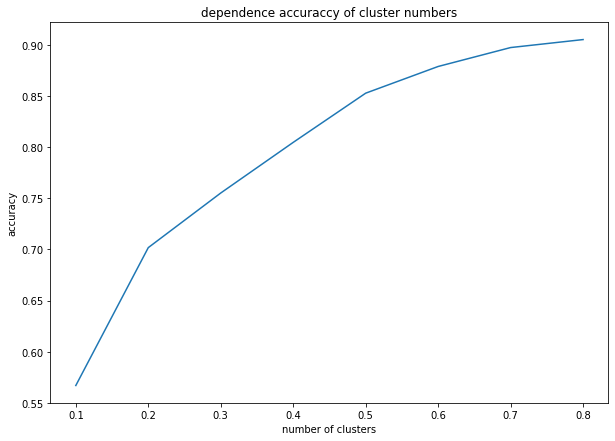

In [6]:
plt.figure(figsize = (10, 7))
plt.plot(cluster_ratio, accuracy)

plt.xlabel('number of clusters')
plt.ylabel('accuracy')
plt.title('dependence accuraccy of cluster numbers')

### Выводы

   1. Без дополнительного доубучения запруненая модель выдает неадекватное качество(если бы я был фильтром и мне бы на вход начали давать что-то совершенно другое, я бы тоже удивился), дообучив модель дополнительно, получается приемлемое качество
   
   3. Сохраняем 85% точности снизив вес модели в 2 раза
   
   2. Для более точных результатов надо делать несколько запусков и рисовать доверительные интервалы,более большим моделям давать больше эпох, но надо больше времени

### Улучшения

   1. Так как размеры фильтров достаточно большие (особено в конце сети, 3\*3\*256 = 2304), все объекты почти одинаково разноудалены друг от друга и кластеризации основанные на расстоянии скорее всего работают не так хорошо как хотелось бы. Возможно имело бы смысл попробовать научиться отображать в более маленькое подпространство, там кластеризовать, а из него обратно в наше простраство переводить центры кластеров, это можно сделать ,например, автоэнкодером.
    
   2. Можно придумать более сложный алгоритм для подбора количества кластеров, чем выбирать их руками. Например для такой задачи подойдет генетический алгоритм или имитации отжига, это было бы интересно.
   
   3. Можно попромовать другие кластеризации позволяющие задавать число кластеров, например агломеративную кластеризацию.
   
   4. После такого прунинга можно еще попробовать занулить маленькие веса + квантизировать